In [1]:
import os
import scipy.io as sio
import sys 
import h5py as hp
import argparse
import random
from random import choices, choice
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from IPython.display import HTML, display, Image
from numpy.fft import ifft2,fft2,fft,ifft,fftfreq, fftshift
from scipy.signal import convolve2d, correlate2d
from IPython.display import HTML, display, Image
import time
from tqdm.auto import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from tifffile import imread
from torchsummary import summary
from torch.nn.utils import spectral_norm
import itertools


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def rebin1d(arr, new_shape):
    shape = (new_shape, arr.shape[0] // new_shape)
    return arr.reshape(shape).mean(-1)

def normalize(x):
    return (x-np.amin(x))/(np.amax(x)-np.amin(x))

def centralpadding(arr, new_shape):
    if new_shape[0]>=arr.shape[0]:
        newarr = np.zeros(new_shape,dtype=complex)
        newarr[(new_shape[0] - arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (new_shape[1] - arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ] = arr
    else:
        newarr= arr[(-new_shape[0] + arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (-new_shape[1] + arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ]
    return newarr

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def moving_average_smooth(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec
def autocor2d(I):
    f = fft2(I)
    f = np.absolute(f)**2
    autocor2d = ifftshift(ifft2(f))/I.shape[0]/I.shape[1]
    return autocor2d

def axis1norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        Y[i,:] = X[i,:]/np.mean(X[i,:]**1)
    return Y

def axis0norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        Y[:,i] = X[:,i]/np.mean(X[:,i]) 
    return Y

def ReLU(x):
    return x * (x > 0)


name = [#one interval
        '0-106 μm',
        '106-180 μm',
        '180-250 μm',
        '250-300 μm',
        '300-355 μm',
        '355-425 μm',
        '425-500 μm',
        '500-1000 μm',
        #two interval
        '106-250 μm',
        '180-300 μm',
        '250-355 μm',
        '300-425 μm',
        '355-500 μm',
        #three interval
        '180-355 μm',
        '250-425 μm',
        '300-500 μm',
        '355-1000 μm',
        #four interval
        '180-425 μm',
        '250-500 μm',
        #five interval
        '180-500 μm']



In [2]:
#load the measured autocorrelations and PSDs
data = np.load('../expdata/ASI1830MM_data/20curves_PSD_cumul_auto_sa.npz')
PSD_exp = data["PSD_exp"]
auto_mean = data['auto_mean']
print(PSD_exp.shape)

(20, 20, 192)


In [3]:

x = np.arange(-32, 32, 1)
y = np.arange(-32, 32, 1)
xx, yy = np.meshgrid(x, y, sparse=True)
u = np.sqrt(xx**2 + yy**2)

#### important parameter #####
#can be calculated from the parameters in the optics, or fit from the side lobe positions. 
#There two methods gives the a close D value.
D=1.49 

#the starting size and ending size
d = 1.49/4800*1200  #4800um is the beam spot size. 1200um is the maximum size we interested in 
d_start = d/1200*10 #10um is the minimum size we interested in 
##############################

delta = 0.0001
psd_pixel = 192

#Define the forward operators
H = np.zeros((64,64,psd_pixel)) #psd_pixel x height x width
r = np.linspace(d_start, d, psd_pixel)

for i in range(H.shape[-1]):
    H[:,:,i] = np.sin(r[i]*(u+delta)) /(u+delta)#/(r[i]+delta)
##############################
print(H.shape)


(64, 64, 192)


In [4]:
#Generate the synthetic dataest

#beta distributions
def beta(x,a,b):
    return x**(a-1)*(1-x)**(b-1)

S = 2000
Nd = 192

auto_sim = np.zeros((S,64,64))
PSD_sim = np.zeros((S,Nd))
cumul_sim = np.zeros((S,Nd))

for i in tqdm(range(S)):
    #generate two parameters for the beta distribution
    u1=np.random.random_sample()*0.5+0.1    #0.15-0.5
    v1=np.random.random_sample()*45+10   #10-50
    a1=u1*v1
    b1=(1-u1)*v1

    PSD_t=beta(np.linspace(0,1,Nd),a1,b1)
    PSD_t=PSD_t/(np.arange(Nd)+3)**6 # devide by r^6 to mimic the long tail effect from the measured PSD
    PSD_t = PSD_t/np.sum(PSD_t)
    
    cumul_sim[i]=np.flip(np.cumsum(np.flip(PSD_t)))
    cumul_sim[i]=cumul_sim[i]/cumul_sim[i,0]
        
    PSD_sim[i]=PSD_t
    
    #apply the forward operator
    z0 = np.abs(2*np.sin(D/2*(u+delta)) /(u+delta)/D)**2 
    z1 = np.abs(np.matmul(H,PSD_sim[i]))**2
    z1 = z1/np.amax(z1)
    #get the 
    auto_sim[i] = z1*z0


In [5]:
#generate calculation images from measured PSDs
auto_expgen = np.zeros((20,20,64,64))

for i in tqdm(range(20)):
    for j in (range(20)):
        
        z0 = np.abs(2*np.sin(D/2*(u+delta)) /(u+delta)/D)**2
        z1 = np.abs(np.matmul(H,PSD_exp[i,j]))**2
        z1 = z1/np.amax(z1)
        auto_expgen[i] = z1*z0


<ipython-input-9-d616d3c94140>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


(0.0, 64.0, 0.0, 64.0)

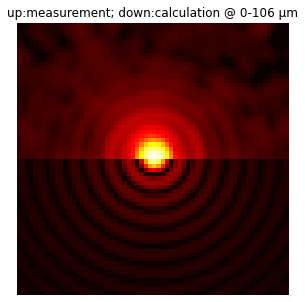

In [9]:
#plot some calculations from the measured PSD.
#the selected index 
plot_idx = 0

z0 = np.abs(2*np.sin(D/2*(u+delta)) /(u+delta)/D)**1
z1 = np.abs(np.matmul(H,PSD_exp[plot_idx,-1]))
z1 = z1/np.amax(z1)

plot_cal = z1*z0
plot_exp = np.abs(auto_mean[plot_idx,:,:])**0.125
plot_exp = ReLU(plot_exp-0.29)
plot_exp = normalize(plot_exp)
plot_final = np.zeros((64,64))
plot_final[0:32] = plot_cal[0:32]
plot_final[32:64] = plot_exp[32:64]

plt.figure(figsize=(5,5))
plt.pcolormesh(plot_final,label=name[plot_idx], cmap=plt.cm.hot,vmin=0)
# plt.colorbar()
plt.axes().set_aspect('equal')
plt.title("up:measurement; down:calculation @ " + name[plot_idx])
plt.axis('off')
